# TAREA 1: REDES NEURONALES CONVOLUCIONALES (CCNS)

**Diego Andrés Sapunar Opazo**

**Fecha de Entrega: 24 de Abril**

## Objetivo

Estimad@s, en esta actividad tendrán la oportunidad de poner en práctica sus conocimientos sobre aprendizaje profundo (deep learning). En particular, podrán experimentar con las técnicas que discutimos en clases para implementar Redes Neuronales Convolucionales (Convolutional Neural Nets o CNNs). Adicionalmente podrán ver en vivo y en directo el poder de las GPUs para acelerar el entrenamiento de redes de aprendizaje profundo.


## Parte 0: Import Packages

In [1]:
#Definicion de librerias con la funciones que seran utilizadas por Keras.

import GPUtil as GPU
import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Activation, Dropout, Flatten,GlobalAveragePooling2D 
from keras.callbacks import ModelCheckpoint

from keras.preprocessing.image import ImageDataGenerator

import os

import shutil

from keras import applications

import pickle
import psutil
import humanize

%matplotlib inline
from matplotlib import pyplot as plt


Using TensorFlow backend.


In [2]:
# https://stackoverflow.com/questions/48750199/google-colaboratory-misleading-information-about-its-gpu-only-5-ram-available
GPUs = GPU.getGPUs()
gpu = GPUs[0] # we have only one GPU @ SCL host
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 30.2 GB  | Proc size: 288.8 MB
GPU RAM Free: 10680MB | Used: 495MB | Util   4% | Total 11175MB


## Parte 1: VGG-19 (30%)

In [57]:
# Definicion de contenedor

modelVGG19 = Sequential()

In [58]:
# Primer bloque de VGG19.

modelVGG19.add(Conv2D(64, (3, 3), input_shape=(224, 224, 3), strides=(1, 1), 
                      activation="relu", padding="same", name='conv1_1'))
modelVGG19.add(Conv2D(64, (3, 3), strides=(1, 1), activation="relu", 
                      padding="same", name='conv1_2'))
print('Before Max-Pooling', modelVGG19.output_shape) # dims de la red antes de MaxPooling 
modelVGG19.add(MaxPooling2D((2,2), strides=(2,2), name='maxpool1')) 
print('After Max-Pooling: ', modelVGG19.output_shape) # dims de la red despues de MaxPooling

Before Max-Pooling (None, 224, 224, 64)
After Max-Pooling:  (None, 112, 112, 64)


In [59]:
# Summary primer bloque

modelVGG19.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
maxpool1 (MaxPooling2D)      (None, 112, 112, 64)      0         
Total params: 38,720
Trainable params: 38,720
Non-trainable params: 0
_________________________________________________________________


### Actividad 1

In [60]:
# Segundo bloque de VGG19.

modelVGG19.add(Conv2D(128, (3, 3), strides=(1, 1), 
                      activation="relu", padding="same", name='conv2_1'))
modelVGG19.add(Conv2D(128, (3, 3), strides=(1, 1), 
                      activation="relu", padding="same", name='conv2_2'))

print('Before Max-Pooling', modelVGG19.output_shape) # dims de la red antes de MaxPooling 
modelVGG19.add(MaxPooling2D((2,2), strides=(2,2), name='maxpool2'))
print('After Max-Pooling: ', modelVGG19.output_shape) # dims de la red despues de MaxPooling

Before Max-Pooling (None, 112, 112, 128)
After Max-Pooling:  (None, 56, 56, 128)


In [61]:
# Summary hasta segundo bloque

modelVGG19.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
maxpool1 (MaxPooling2D)      (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
maxpool2 (MaxPooling2D)      (None, 56, 56, 128)       0         
Total params: 260,160
Trainable params: 260,160
Non-trainable params: 0
_________________________________________________________________


Vemos que la Red hasta este punto tiene **260.160 parametros.**

Como vimos en clases, cada filtro tiene como parametros cada una de sus "neuronas" es decir, su altura por ancho por profundidad (del input), más un 1 (debido al bias). A su vez, son tantos filtros como la profundidad del output.

Entonces la primera capa convolucional del primer bloque **conv1_1** tiene filtros de 3x3, 3 mapas de activación de input, entonces son de 3x3x3, y son 64 mapas de activación de salida. Entonces seria (3x3x3 +1) x 64 = 1.792.

Luego la segunda capa convolucional del primer bloque, igual que el anterior pero es aplicado sobre 64 mapas y no 3 **conv1_2** (3x3x64 +1) x 64 = 36.928.

Luego la primera capa convolucional del segundo bloque, es de  filtros de 3x3, pero con una profundida de 128 de output, y es aplicado sobre la capa anterior de profundidad 64. Entonces  **conv2_1** (3x3x64 +1) x 128 = 73.856.

Finalmente, la segunda capa convolucional del segundo bloque, es de filtros de 3x3, con una profundidad de 128 de input, y es aplicada sobre la capa enterior de profundidad 128. Entonces **conv2_2** (3x3x128 + 1) * 128 = 147.584.

Sumando estos parametros nos da un total de: **260.160 parametros**

--

También, es importante mencionar el rol del Max-Pooling, y como este disminuye las dimensiones de alto por ancho. En este caso de 112x112 a 56x56

### Actividad 2

In [62]:
# Tercer bloque de VGG19.

modelVGG19.add(Conv2D(256, (3, 3), strides=(1, 1), 
                      activation='relu', padding="same", name='conv3_1'))

modelVGG19.add(Conv2D(256, (3, 3), strides=(1, 1), 
                      activation='relu', padding="same", name='conv3_2'))

modelVGG19.add(Conv2D(256, (3, 3), strides=(1, 1), 
                      activation='relu', padding="same", name='conv3_3'))

modelVGG19.add(Conv2D(256, (3, 3), strides=(1, 1), 
                      activation='relu', padding="same", name='conv3_4'))

print('Before Max-Pooling', modelVGG19.output_shape) # dims de la red antes de MaxPooling 
modelVGG19.add(MaxPooling2D((2,2), strides=(2,2), name='maxpool3'))
print('After Max-Pooling: ', modelVGG19.output_shape) # dims de la red despues de MaxPooling

Before Max-Pooling (None, 56, 56, 256)
After Max-Pooling:  (None, 28, 28, 256)


In [63]:
# Summary hasta tercer bloque

modelVGG19.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
maxpool1 (MaxPooling2D)      (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
maxpool2 (MaxPooling2D)      (None, 56, 56, 128)       0         
_________________________________________________________________
conv3_1 (Conv2D)             (None, 56, 56, 256)       295168    
__________

Primero me gustaria mencionar que After Max-Pooling la shape de mi red es correcta, siendo de 28x28x256.

--

Luego para ver las dimensiones de este tercer bloque tenemos:
Entonces la primera capa convolucional del tecer bloque, **conv3_1** tiene filtros de 3x3, 128 mapas de activación de input, entonces son de 3x3x128, y son 256 mapas de activación de salida
. Entonces seria (3x3x128 +1) x 256 = 295.168.

Luego la segunda capa convolucional del tercer bloque, **conv3_2**, igual que el anterior pero es aplicado sobre 256 mapas y no 128. (3x3x256 +1) x 256 = 590.080.

Luego la tecerca capa convolucional del tercer bloque, **conv3_3**, igual que el anterior, aplicado sobre 256 mapas. (3x3x256 +1) x 256 = 590.080.

Luego la cuarta capa convolucional del tercer bloque, **conv3_4**, igual que el anterior, aplicado sobre 256 mapas. (3x3x256 +1) x 256 = 590.080.

Sumando estos parametros nos da un total de: **2.325.568 parametros**


### Actividad 3

In [64]:
# Cuarto bloque de VGG19.

modelVGG19.add(Conv2D(512, (3, 3), strides=(1, 1),
          activation='relu', padding='same', name='conv4_1'))

modelVGG19.add(Conv2D(512, (3, 3), strides=(1, 1),
          activation='relu', padding='same', name='conv4_2'))

modelVGG19.add(Conv2D(512, (3, 3), strides=(1, 1),
          activation='relu', padding='same', name='conv4_3'))

modelVGG19.add(Conv2D(512, (3, 3), strides=(1, 1),
          activation='relu', padding='same', name='conv4_4'))

print('Before Max-Pooling', modelVGG19.output_shape) # dims de la red antes de MaxPooling 
modelVGG19.add(MaxPooling2D((2,2), strides=(2,2), name='maxpool4'))
print('After Max-Pooling: ', modelVGG19.output_shape) # dims de la red despues de MaxPooling

Before Max-Pooling (None, 28, 28, 512)
After Max-Pooling:  (None, 14, 14, 512)


In [65]:
# Summary hasta cuarto bloque

modelVGG19.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
maxpool1 (MaxPooling2D)      (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
maxpool2 (MaxPooling2D)      (None, 56, 56, 128)       0         
_________________________________________________________________
conv3_1 (Conv2D)             (None, 56, 56, 256)       295168    
__________

In [66]:
# Quinto bloque de VGG19.

modelVGG19.add(Conv2D(512, (3, 3), strides=(1, 1),
          activation='relu', padding='same', name='conv5_1'))

modelVGG19.add(Conv2D(512, (3, 3), strides=(1, 1),
          activation='relu', padding='same', name='conv5_2'))

modelVGG19.add(Conv2D(512, (3, 3), strides=(1, 1),
          activation='relu', padding='same', name='conv5_3'))

modelVGG19.add(Conv2D(512, (3, 3), strides=(1, 1),
          activation='relu', padding='same', name='conv5_4'))

print('Before Max-Pooling', modelVGG19.output_shape) # dims de la red antes de MaxPooling 
modelVGG19.add(MaxPooling2D((2,2), strides=(2,2), name='maxpool5'))
print('After Max-Pooling: ', modelVGG19.output_shape) # dims de la red despues de MaxPooling

Before Max-Pooling (None, 14, 14, 512)
After Max-Pooling:  (None, 7, 7, 512)


In [67]:
# Summary hasta quinto bloque

modelVGG19.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
maxpool1 (MaxPooling2D)      (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
maxpool2 (MaxPooling2D)      (None, 56, 56, 128)       0         
_________________________________________________________________
conv3_1 (Conv2D)             (None, 56, 56, 256)       295168    
__________

Para **no ser repetitivos con los puntos anterioes,** no vamos a repetir la explicación de los calculos. Sin embargo, podemos observar que las salida de cada una de las capas es lo que esperamos en acorde a la figura del enunciado. Es decir, del bloque cuatro ya llevamos **10.585.152 parametros**, tambien es importante destacar el Max-Pool que ocurre a la salida del bloque 4, el cual lleva de las dimensiones **28x28x512** a **14x14x512**. Vemos tambien que este bloque generó una cantidad impresionante de parámetros, pasando de **2.325.568 parametros** a ****10.585.152 parametros**** (un aporte de 8.259.584 parametros).

Luego el bloque 5, tiene **20.024.384 parametros**, tambien es importante destacar el Max-Pool que ocurre a la salida del bloque 5, el cual lleva de las dimensiones **14x14x512** a **7x7x512**. Vemos tambien que este bloque generó una cantidad impresionante de parámetros, pasando de **10.585.152 parametros** a ****20.024.384 parametros**** (un aporte de 9.439.232 parametros).

Vamos viendo como cada bloque que es más profundo va generando mayor cantidad de parametros.

### Actividad 4

In [68]:
# Transformar Salida 3D a 1D

modelVGG19.add(Flatten(name='flatten'))
print('Shape 1D: ', modelVGG19.output_shape)

Shape 1D:  (None, 25088)


Vemos que l dimension de salida es en !D lo cual hace mucho sentido ya que estamos entrando a capas de conexion densa. Esta es de **25.088**, lo cual hace sentido, dado que antes de aplicar Flatten teniamos una entrada de 7x7x512, y si multiplicamos 7x7x512 es **25.088**. Entonces vemos que lo que estamos cambiando aca es solo la forma que estamos representando, no el numero de neuronas.

### Actividad 5

In [69]:
# Sexto bloque de VGG19.

modelVGG19.add(Dense(4096, activation='relu', name='fc1'))
print('Shape FC1: ', modelVGG19.output_shape)

Shape FC1:  (None, 4096)


In [70]:
# Summary hasta sexto bloque

modelVGG19.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
maxpool1 (MaxPooling2D)      (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
maxpool2 (MaxPooling2D)      (None, 56, 56, 128)       0         
_________________________________________________________________
conv3_1 (Conv2D)             (None, 56, 56, 256)       295168    
__________

Vemos que la salida es de **4096 neuronas**, lo que esta correcto de acuerdo a la figura del enunciado. Ahora es **IMPRESIONANTE** el número de parametros que se genera en esta capa densa, siendo ahora un total de **122.788.928 parametros** 

### Actividad 6

In [71]:
# Septimo bloque de VGG19.

modelVGG19.add(Dense(4096, activation='relu', name='fc2'))
print('Shape FC2: ', modelVGG19.output_shape)

Shape FC2:  (None, 4096)


In [72]:
# Summary hasta septimo bloque

modelVGG19.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
maxpool1 (MaxPooling2D)      (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
maxpool2 (MaxPooling2D)      (None, 56, 56, 128)       0         
_________________________________________________________________
conv3_1 (Conv2D)             (None, 56, 56, 256)       295168    
__________

In [73]:
# Octavo bloque de VGG19.

modelVGG19.add(Dense(1000, activation='softmax', name='salida'))
print('Shape salida: ', modelVGG19.output_shape)

Shape salida:  (None, 1000)


In [74]:
# Summary red

modelVGG19.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
maxpool1 (MaxPooling2D)      (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
maxpool2 (MaxPooling2D)      (None, 56, 56, 128)       0         
_________________________________________________________________
conv3_1 (Conv2D)             (None, 56, 56, 256)       295168    
__________

Revisando estas dos últimos bloques; en el bloque 7 tiene una salida de **4096**, lo que es correcto de acorde a la figura del enunciado, lo mismo con las salida del bloque 8 de **1000**.

Vemos también que el bloque 7 llegamos a **139.570.240 parametros**, y en el bloque 8 llegamos a **143.667.240 parametros**. Estas capas son FC, entonces es todos con todos más un bias por cada una de las salidas (inputxoutput + output). 

Teniendo en total en la red  **143.667.240 parametros** y respecto al numero total de filtros es: 64 + 64 + 128 + 128 + 256 + 256 + 256 + 256 + 512 + 512 + 512 + 512 + 512 + 512 + 512 + 512 = **5.504**.

Luego vemos, que los bloques con más filtros corresponden a los ultimos bloques convolucionales (bloque 4 y 5), esto se debe a que a este punto se deben "aprender" patrones más complejos. Hagamos la analogía que hicimos en clases con el lenguaje natural, al principio sólo tenemos letras (facil de aprender), luego tenemos silabas (un poco más dificil) hasta lleagr a oraciones complejas, lo mismo pasa en este caso con imagenes. 

En el caso de los parametros, la primera capa FC (bloque 7) aporta casi 103 millones de parametros, también me gustaria mencionar que la parte Densa de la Red es la que aporta más parametros. 

Como comentario general, vemos que cada vez que avanzamos en profundidad, el aporte de cada capa (o bloque) en terminos de parametros aumenta considerablemente, esto se debe a la misma analogia de las letras y oraciones, mas profundo se arman combinaciones mucho mas dificiles de aprender.

Estas arquitrcturas profundas estan muy de moda, sobre todo por el manejo de grandes volumenes de datos. En el caso que no tuvieramos tantos datos no se justifica utilizar estas arquitecturas profundas, dado que caeriamos inmediatamente en un sobreentrenamiento.


## Parte 2: Reconocimiento de Visual (70%)

### 2.1 mini-ImageNet

#### Actividad 7

Primero, la red que seleccione es la Resnet-50, la cual, tiene un total de 23.792.612 parametros, de los cuales 23.7380.492 son parametros entrenables y 53.120 no lo son. 

Luego realize **6 experimentos distintos**, para manejar esto, fui guardando un **Checkpoint** con sólo los pesos de cada modelo y si este mejoraba, con esto podía volver atras o si sufría alguna descconexion. También luego de entrenar guarde el historial de cada uno de los entrenamientos, para luego poder anlizarlos mediante gráficos.

En fin, para cada uno de lo experimentos se realizaron 25 epocas, lo que en la experiencia estuvo bien, dado que los experimentos convergieron bastante antes de la epoca 25.

Para los experimentos se utilizaron dos tipos distintos de algoritmos de optimización, tres de ellos con **adam** el cual funciona bastante bien y es rapido y para os otros tres se utilizó **adadelta

Otro de los parametros que se fueron ajustando (además de las epocas y el algoritmo de optimización) fue el tamaño del mini-batch, donde se tomaron 15, 30 y 45. Donde finalmente, no se observaron diferencias.

Respecto a la estrategia de validación, se utilizo un set de validación correspondiente al 15% de los datos, con lo que podemos ir validando el modelo en cada una de las epocas. También se tiene un set de test correspondiente al 15%.

Respecto a los tiempos de ejecución:

Experimento |Tiempo de Ejecucion (secs)
--- | --- 
*Adam, Batch Size=15* | 3000 
*Adam, Batch Size=30* | 2850 
*Adam, Batch Size=45* | 2380 
*Adadelta, Batch Size=15* | 5850
*Adadelta, Batch Size=30* | 3175
*Adadelta, Batch Size=45* | 2475

Con lo anterior podemos ver que el Algorimo de Optimización Adam es más rápido que Adadelta. También se observa que a un mayo Batch Size, el tiempo de ejecución en segundos es menor (lo que hace sentido claramente).

#### Spling Data

Vamos a separar nuestra data mini_ImageNet original entregada por los ayudantes en los sets de entrenamiento (train), de test y validacion (val). En este caso toma tomare el 70% al train, y 15% al test y al val respectivamente.

In [5]:
# Source: https://www.pythonforbeginners.com/os/python-the-shutil-module

original_data_directory = './mini_ImageNet/images/'
dest_data_directory = './data/'

for clase in os.listdir(original_data_directory):
    # Creo la clase en train, test y val
    for _set in ['train', 'test', 'val']:
        if not os.path.exists(dest_data_directory + _set + '/' + clase):
            os.mkdir(dest_data_directory + _set + '/' + clase)
            
    # Entro a cada clase, agarro el 70% lo muevo a train, 15% a test y 15% a val
    for contador, imagen in enumerate(os.listdir(original_data_directory + clase)):
        original_image = original_data_directory + clase + '/' + imagen
        if contador < 420:  # se va a train:
            dest_image = dest_data_directory + 'train/' + clase + '/' + imagen
            if not os.path.exists(dest_image):
                shutil.copy(original_image, dest_image)
        
        elif contador < 510:  # se va test
            dest_image = dest_data_directory + 'test/' + clase + '/' + imagen
            if not os.path.exists(dest_image):
                shutil.copy(original_image, dest_image)
        
        else:  # se va a val
            dest_image = dest_data_directory + 'val/' + clase + '/' + imagen
            if not os.path.exists(dest_image):
                shutil.copy(original_image, dest_image)

#### Defining Hyperparameters

In [8]:
# Definiendo algunos parametros CONSTANTES:

# Numero de clases, por default del ejercicio son 100, constante
num_clases = 100

# dimensiones de las imagenes (tambien por default del ejercicio, constante)
img_width, img_height = 84, 84  

#### 1) Adam: 25 epochs, 15 batch_size

In [ ]:
# Source: https://github.com/priya-dwivedi/Deep-Learning/blob/master/resnet_keras/Residual_Network_Keras.ipynb
base_model = applications.resnet50.ResNet50(weights= None, include_top=False, input_shape= (img_height,img_width,3))

In [20]:
# Definiendo parametros

# numero de epocas para entrenar, uno de los hiperparametros que voy a variar
epochs = 25  

# batch size, uno de los hiperparametros que voy a variar

batch_size = 15 

# Optimizador para entrenar, uno de los hiperparametros que voy a variar
opt = 'adam'



##### Loading Images into Keras

In [21]:
# Source: https://machinelearningmastery.com/how-to-load-large-datasets-from-directories-for-deep-learning-with-keras/
# Comment of Paulo Henrique Zen Messerschmidt

# create generator
datagen = ImageDataGenerator()

train_set = datagen.flow_from_directory('./data/train/', 
                                       target_size=(img_width, img_height),
                                       batch_size=batch_size)

test_set = datagen.flow_from_directory('./data/test/', 
                                       target_size=(img_width, img_height),
                                       batch_size=batch_size)

val_set = datagen.flow_from_directory('./data/val/', 
                                       target_size=(img_width, img_height),
                                       batch_size=batch_size)

Found 42000 images belonging to 100 classes.
Found 9000 images belonging to 100 classes.
Found 9000 images belonging to 100 classes.


In [22]:

x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(num_clases, activation= 'softmax')(x)
    
model = Model(inputs = base_model.input, outputs = predictions)

#compile 
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 84, 84, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 90, 90, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 42, 42, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 42, 42, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [23]:
# Source: https://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/
# https://github.com/keras-team/keras/issues/8540/
# https://keras.io/callbacks/
# https://machinelearningmastery.com/check-point-deep-learning-models-keras/

# checkpoint
filepath='./models/1/weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max', save_weights_only=True)
callbacks_list = [checkpoint]

# training
hist = model.fit_generator(generator=train_set,
                              validation_data=val_set,
                              epochs = epochs,
                              verbose = 1,
                              callbacks=callbacks_list,
                              steps_per_epoch=42000/batch_size,
                              validation_steps=9000/batch_size)


Epoch 1/25
2800/2800 [==============================] - 209s 75ms/step - loss: 5.4321 - acc: 0.0186 - val_loss: 5.4767 - val_acc: 0.0126
Epoch 2/25
2800/2800 [==============================] - 199s 71ms/step - loss: 5.3048 - acc: 0.0272 - val_loss: 11.0084 - val_acc: 0.0252
Epoch 3/25
2800/2800 [==============================] - 199s 71ms/step - loss: 4.8735 - acc: 0.0426 - val_loss: 4.2939 - val_acc: 0.0550
Epoch 4/25
2800/2800 [==============================] - 199s 71ms/step - loss: 4.1114 - acc: 0.0737 - val_loss: 3.9986 - val_acc: 0.1000
Epoch 5/25
2800/2800 [==============================] - 199s 71ms/step - loss: 3.8706 - acc: 0.1102 - val_loss: 3.8499 - val_acc: 0.1313
Epoch 6/25
2800/2800 [==============================] - 199s 71ms/step - loss: 3.6153 - acc: 0.1511 - val_loss: 4.4922 - val_acc: 0.1424
Epoch 7/25
2800/2800 [==============================] - 199s 71ms/step - loss: 3.3485 - acc: 0.1992 - val_loss: 3.8735 - val_acc: 0.1500
Epoch 8/25
2800/2800 [==================

In [27]:
with open('./history/1', 'wb') as file:
        pickle.dump(hist.history, file)

#### 2) Adam: 25 epochs, 30 batch_size

In [6]:
# Source: https://github.com/priya-dwivedi/Deep-Learning/blob/master/resnet_keras/Residual_Network_Keras.ipynb
base_model = applications.resnet50.ResNet50(weights= None, include_top=False, input_shape= (img_height,img_width,3))

/home/cuda/.local/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [7]:
# Definiendo parametros

# numero de epocas para entrenar, uno de los hiperparametros que voy a variar
epochs = 25  

# batch size, uno de los hiperparametros que voy a variar

batch_size = 30 

# Optimizador para entrenar, uno de los hiperparametros que voy a variar
opt = 'adam'


In [8]:
# Source: https://machinelearningmastery.com/how-to-load-large-datasets-from-directories-for-deep-learning-with-keras/
# Comment of Paulo Henrique Zen Messerschmidt

# create generator
datagen = ImageDataGenerator()

train_set = datagen.flow_from_directory('./data/train/', 
                                       target_size=(img_width, img_height),
                                       batch_size=batch_size)

test_set = datagen.flow_from_directory('./data/test/', 
                                       target_size=(img_width, img_height),
                                       batch_size=batch_size)

val_set = datagen.flow_from_directory('./data/val/', 
                                       target_size=(img_width, img_height),
                                       batch_size=batch_size)

Found 42000 images belonging to 100 classes.
Found 9000 images belonging to 100 classes.
Found 9000 images belonging to 100 classes.


In [9]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(num_clases, activation= 'softmax')(x)
    
model = Model(inputs = base_model.input, outputs = predictions)

#compile 
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


In [12]:
# Source: https://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/
# https://github.com/keras-team/keras/issues/8540/
# https://keras.io/callbacks/
# https://machinelearningmastery.com/check-point-deep-learning-models-keras/

# checkpoint
filepath='./models/2/weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max', save_weights_only=True)
callbacks_list = [checkpoint]

# training
hist = model.fit_generator(generator=train_set,
                              validation_data=val_set,
                              epochs = epochs,
                              verbose = 1,
                              callbacks=callbacks_list,
                              steps_per_epoch=42000/batch_size,
                              validation_steps=9000/batch_size)


Epoch 1/25
1400/1400 [==============================] - 114s 82ms/step - loss: 4.5684 - acc: 0.0699 - val_loss: 4.7038 - val_acc: 0.0621
Epoch 2/25
1400/1400 [==============================] - 114s 82ms/step - loss: 4.7161 - acc: 0.0525 - val_loss: 4.7519 - val_acc: 0.0602
Epoch 3/25
1400/1400 [==============================] - 114s 82ms/step - loss: 4.2074 - acc: 0.0801 - val_loss: 3.8523 - val_acc: 0.1124
Epoch 4/25
1400/1400 [==============================] - 114s 82ms/step - loss: 3.7163 - acc: 0.1328 - val_loss: 3.6231 - val_acc: 0.1591
Epoch 5/25
1400/1400 [==============================] - 114s 82ms/step - loss: 3.4490 - acc: 0.1822 - val_loss: 3.9417 - val_acc: 0.1563
Epoch 6/25
1400/1400 [==============================] - 114s 82ms/step - loss: 3.2331 - acc: 0.2172 - val_loss: 3.5135 - val_acc: 0.1960
Epoch 7/25
1400/1400 [==============================] - 114s 82ms/step - loss: 3.0231 - acc: 0.2546 - val_loss: 3.3193 - val_acc: 0.2126
Epoch 8/25
1400/1400 [===================

In [13]:
with open('./history/2', 'wb') as file:
        pickle.dump(hist.history, file)

#### 3) Adam: 25 epochs, 45 batch_size

In [14]:
# Source: https://github.com/priya-dwivedi/Deep-Learning/blob/master/resnet_keras/Residual_Network_Keras.ipynb
base_model = applications.resnet50.ResNet50(weights= None, include_top=False, input_shape= (img_height,img_width,3))

/home/cuda/.local/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [15]:
# Definiendo parametros

# numero de epocas para entrenar, uno de los hiperparametros que voy a variar
epochs = 25  

# batch size, uno de los hiperparametros que voy a variar

batch_size = 45 

# Optimizador para entrenar, uno de los hiperparametros que voy a variar
opt = 'adam'


In [16]:
# Source: https://machinelearningmastery.com/how-to-load-large-datasets-from-directories-for-deep-learning-with-keras/
# Comment of Paulo Henrique Zen Messerschmidt

# create generator
datagen = ImageDataGenerator()

train_set = datagen.flow_from_directory('./data/train/', 
                                       target_size=(img_width, img_height),
                                       batch_size=batch_size)

test_set = datagen.flow_from_directory('./data/test/', 
                                       target_size=(img_width, img_height),
                                       batch_size=batch_size)

val_set = datagen.flow_from_directory('./data/val/', 
                                       target_size=(img_width, img_height),
                                       batch_size=batch_size)

Found 42000 images belonging to 100 classes.
Found 9000 images belonging to 100 classes.
Found 9000 images belonging to 100 classes.


In [17]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(num_clases, activation= 'softmax')(x)
    
model = Model(inputs = base_model.input, outputs = predictions)

#compile 
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


In [18]:
# Source: https://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/
# https://github.com/keras-team/keras/issues/8540/
# https://keras.io/callbacks/
# https://machinelearningmastery.com/check-point-deep-learning-models-keras/

# checkpoint
filepath='./models/3/weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max', save_weights_only=True)
callbacks_list = [checkpoint]

# training
hist = model.fit_generator(generator=train_set,
                              validation_data=val_set,
                              epochs = epochs,
                              verbose = 1,
                              callbacks=callbacks_list,
                              steps_per_epoch=42000/batch_size,
                              validation_steps=9000/batch_size)


Epoch 1/25
934/933 [==============================] - 107s 115ms/step - loss: 4.7236 - acc: 0.0384 - val_loss: 5.1112 - val_acc: 0.0569
Epoch 2/25
934/933 [==============================] - 93s 100ms/step - loss: 4.3004 - acc: 0.0823 - val_loss: 7.8294 - val_acc: 0.0270
Epoch 3/25
934/933 [==============================] - 94s 100ms/step - loss: 4.1459 - acc: 0.1103 - val_loss: 6.1859 - val_acc: 0.0132
Epoch 4/25
934/933 [==============================] - 94s 100ms/step - loss: 4.0396 - acc: 0.1286 - val_loss: 3.7708 - val_acc: 0.1524
Epoch 5/25
934/933 [==============================] - 94s 101ms/step - loss: 4.1201 - acc: 0.1163 - val_loss: 4.4875 - val_acc: 0.1164
Epoch 6/25
934/933 [==============================] - 94s 101ms/step - loss: 3.9759 - acc: 0.1388 - val_loss: 4.2652 - val_acc: 0.1233
Epoch 7/25
934/933 [==============================] - 94s 101ms/step - loss: 3.7577 - acc: 0.1776 - val_loss: 4.8695 - val_acc: 0.0779
Epoch 8/25
934/933 [==============================] - 

In [19]:
with open('./history/3', 'wb') as file:
        pickle.dump(hist.history, file)

#### 4) Adadelta: 25 epochs, 15 batch_size

In [31]:
# Source: https://github.com/priya-dwivedi/Deep-Learning/blob/master/resnet_keras/Residual_Network_Keras.ipynb
base_model = applications.resnet50.ResNet50(weights= None, include_top=False, input_shape= (img_height,img_width,3))

In [32]:
# Definiendo parametros

# numero de epocas para entrenar, uno de los hiperparametros que voy a variar
epochs = 25  

# batch size, uno de los hiperparametros que voy a variar

batch_size = 15 

# Optimizador para entrenar, uno de los hiperparametros que voy a variar
opt = 'adadelta'



In [33]:
# Source: https://machinelearningmastery.com/how-to-load-large-datasets-from-directories-for-deep-learning-with-keras/
# Comment of Paulo Henrique Zen Messerschmidt

# create generator
datagen = ImageDataGenerator()

train_set = datagen.flow_from_directory('./data/train/', 
                                       target_size=(img_width, img_height),
                                       batch_size=batch_size)

test_set = datagen.flow_from_directory('./data/test/', 
                                       target_size=(img_width, img_height),
                                       batch_size=batch_size)

val_set = datagen.flow_from_directory('./data/val/', 
                                       target_size=(img_width, img_height),
                                       batch_size=batch_size)

Found 42000 images belonging to 100 classes.
Found 9000 images belonging to 100 classes.
Found 9000 images belonging to 100 classes.


In [34]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(num_clases, activation= 'softmax')(x)
    
model = Model(inputs = base_model.input, outputs = predictions)

#compile 
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


In [35]:
# Source: https://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/
# https://github.com/keras-team/keras/issues/8540/
# https://keras.io/callbacks/
# https://machinelearningmastery.com/check-point-deep-learning-models-keras/

# checkpoint
filepath='./models/4/weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max', save_weights_only=True)
callbacks_list = [checkpoint]

# training
hist = model.fit_generator(generator=train_set,
                              validation_data=val_set,
                              epochs = epochs,
                              verbose = 1,
                              callbacks=callbacks_list,
                              steps_per_epoch=42000/batch_size,
                              validation_steps=9000/batch_size)


Epoch 1/25
2800/2800 [==============================] - 251s 90ms/step - loss: 5.2729 - acc: 0.0394 - val_loss: 10.3986 - val_acc: 0.0340
Epoch 2/25
2800/2800 [==============================] - 234s 84ms/step - loss: 4.8304 - acc: 0.0825 - val_loss: 6.2534 - val_acc: 0.0794
Epoch 3/25
2800/2800 [==============================] - 234s 84ms/step - loss: 4.5949 - acc: 0.1170 - val_loss: 4.1053 - val_acc: 0.1101
Epoch 4/25
2800/2800 [==============================] - 235s 84ms/step - loss: 4.2538 - acc: 0.1699 - val_loss: 3.5556 - val_acc: 0.2120
Epoch 5/25
2800/2800 [==============================] - 234s 84ms/step - loss: 4.0342 - acc: 0.2118 - val_loss: 3.8668 - val_acc: 0.1283
Epoch 6/25
2800/2800 [==============================] - 234s 84ms/step - loss: 3.8731 - acc: 0.2437 - val_loss: 4.2163 - val_acc: 0.2516
Epoch 7/25
2800/2800 [==============================] - 234s 84ms/step - loss: 3.6859 - acc: 0.2815 - val_loss: 4.3769 - val_acc: 0.2443
Epoch 8/25
2800/2800 [==================

In [36]:
with open('./history/4', 'wb') as file:
        pickle.dump(hist.history, file)

#### 5) Adadelta: 25 epochs, 30 batch_size

In [19]:
# Source: https://github.com/priya-dwivedi/Deep-Learning/blob/master/resnet_keras/Residual_Network_Keras.ipynb
base_model = applications.resnet50.ResNet50(weights= None, include_top=False, input_shape= (img_height,img_width,3))

In [20]:
# Definiendo parametros

# numero de epocas para entrenar, uno de los hiperparametros que voy a variar
epochs = 25  

# batch size, uno de los hiperparametros que voy a variar

batch_size = 30 

# Optimizador para entrenar, uno de los hiperparametros que voy a variar
opt = 'adadelta'



In [21]:
# Source: https://machinelearningmastery.com/how-to-load-large-datasets-from-directories-for-deep-learning-with-keras/
# Comment of Paulo Henrique Zen Messerschmidt

# create generator
datagen = ImageDataGenerator()

train_set = datagen.flow_from_directory('./data/train/', 
                                       target_size=(img_width, img_height),
                                       batch_size=batch_size)

test_set = datagen.flow_from_directory('./data/test/', 
                                       target_size=(img_width, img_height),
                                       batch_size=batch_size)

val_set = datagen.flow_from_directory('./data/val/', 
                                       target_size=(img_width, img_height),
                                       batch_size=batch_size)

Found 42000 images belonging to 100 classes.
Found 9000 images belonging to 100 classes.
Found 9000 images belonging to 100 classes.


In [22]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(num_clases, activation= 'softmax')(x)
    
model = Model(inputs = base_model.input, outputs = predictions)

#compile 
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
# Source: https://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/
# https://github.com/keras-team/keras/issues/8540/
# https://keras.io/callbacks/
# https://machinelearningmastery.com/check-point-deep-learning-models-keras/

# checkpoint
filepath='./models/5/weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max', save_weights_only=True)
callbacks_list = [checkpoint]

# training
hist = model.fit_generator(generator=train_set,
                              validation_data=val_set,
                              epochs = epochs,
                              verbose = 1,
                              callbacks=callbacks_list,
                              steps_per_epoch=42000/batch_size,
                              validation_steps=9000/batch_size)

Epoch 1/25
1400/1400 [==============================] - 140s 100ms/step - loss: 4.6923 - acc: 0.0555 - val_loss: 4.4692 - val_acc: 0.0761
Epoch 2/25
1400/1400 [==============================] - 127s 91ms/step - loss: 4.3821 - acc: 0.0970 - val_loss: 4.8731 - val_acc: 0.0959
Epoch 3/25
1400/1400 [==============================] - 127s 91ms/step - loss: 4.0476 - acc: 0.1444 - val_loss: 4.7313 - val_acc: 0.1012
Epoch 4/25
1400/1400 [==============================] - 127s 91ms/step - loss: 3.8947 - acc: 0.1726 - val_loss: 3.2970 - val_acc: 0.2104
Epoch 5/25
1400/1400 [==============================] - 127s 91ms/step - loss: 3.5499 - acc: 0.2304 - val_loss: 5.7549 - val_acc: 0.1550
Epoch 6/25
1400/1400 [==============================] - 127s 91ms/step - loss: 3.3651 - acc: 0.2667 - val_loss: 4.5198 - val_acc: 0.1346
Epoch 7/25
1400/1400 [==============================] - 127s 91ms/step - loss: 3.1619 - acc: 0.3082 - val_loss: 3.9168 - val_acc: 0.1532
Epoch 8/25
1400/1400 [==================

In [24]:
with open('./history/5', 'wb') as file:
        pickle.dump(hist.history, file)

#### 6) Adadelta: 25 epochs, 45 batch_size

In [25]:
# Source: https://github.com/priya-dwivedi/Deep-Learning/blob/master/resnet_keras/Residual_Network_Keras.ipynb
base_model = applications.resnet50.ResNet50(weights= None, include_top=False, input_shape= (img_height,img_width,3))

In [26]:
# Definiendo parametros

# numero de epocas para entrenar, uno de los hiperparametros que voy a variar
epochs = 25  

# batch size, uno de los hiperparametros que voy a variar

batch_size = 45 

# Optimizador para entrenar, uno de los hiperparametros que voy a variar
opt = 'adadelta'



In [27]:
# Source: https://machinelearningmastery.com/how-to-load-large-datasets-from-directories-for-deep-learning-with-keras/
# Comment of Paulo Henrique Zen Messerschmidt

# create generator
datagen = ImageDataGenerator()

train_set = datagen.flow_from_directory('./data/train/', 
                                       target_size=(img_width, img_height),
                                       batch_size=batch_size)

test_set = datagen.flow_from_directory('./data/test/', 
                                       target_size=(img_width, img_height),
                                       batch_size=batch_size)

val_set = datagen.flow_from_directory('./data/val/', 
                                       target_size=(img_width, img_height),
                                       batch_size=batch_size)

Found 42000 images belonging to 100 classes.
Found 9000 images belonging to 100 classes.
Found 9000 images belonging to 100 classes.


In [28]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(num_clases, activation= 'softmax')(x)
    
model = Model(inputs = base_model.input, outputs = predictions)

#compile 
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
# Source: https://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/
# https://github.com/keras-team/keras/issues/8540/
# https://keras.io/callbacks/
# https://machinelearningmastery.com/check-point-deep-learning-models-keras/

# checkpoint
filepath='./models/5/weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max', save_weights_only=True)
callbacks_list = [checkpoint]

# training
hist = model.fit_generator(generator=train_set,
                              validation_data=val_set,
                              epochs = epochs,
                              verbose = 1,
                              callbacks=callbacks_list,
                              steps_per_epoch=42000/batch_size,
                              validation_steps=9000/batch_size)

Epoch 1/25
934/933 [==============================] - 115s 123ms/step - loss: 4.6286 - acc: 0.0516 - val_loss: 7.2483 - val_acc: 0.0422
Epoch 2/25
934/933 [==============================] - 99s 106ms/step - loss: 4.0818 - acc: 0.1174 - val_loss: 6.9577 - val_acc: 0.0278
Epoch 3/25
934/933 [==============================] - 99s 106ms/step - loss: 3.9790 - acc: 0.1389 - val_loss: 4.9783 - val_acc: 0.0696
Epoch 4/25
934/933 [==============================] - 99s 106ms/step - loss: 3.6493 - acc: 0.1922 - val_loss: 4.3642 - val_acc: 0.1143
Epoch 5/25
934/933 [==============================] - 99s 106ms/step - loss: 3.5368 - acc: 0.2129 - val_loss: 4.7627 - val_acc: 0.1547
Epoch 6/25
934/933 [==============================] - 99s 106ms/step - loss: 3.5694 - acc: 0.2145 - val_loss: 4.0097 - val_acc: 0.1653
Epoch 7/25
934/933 [==============================] - 99s 106ms/step - loss: 3.2542 - acc: 0.2635 - val_loss: 4.6997 - val_acc: 0.0924
Epoch 8/25
934/933 [==============================] - 

In [30]:
with open('./history/6', 'wb') as file:
        pickle.dump(hist.history, file)

#### Actividad 8

Vamos a ir viendo cada uno de los entrenamientos anteriores.

Source: https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

##### 1) Graficos: Adam: 25 epochs, 15 batch_size

In [2]:
with open('./history/1', 'rb') as f:
    hist = pickle.load(f)

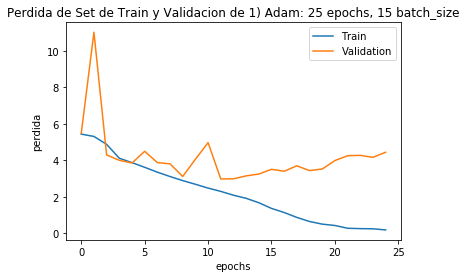

In [8]:
# lines
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])

# title
plt.title("Perdida de Set de Train y Validacion de 1) Adam: 25 epochs, 15 batch_size")

# labels de los ejes
plt.ylabel('perdida')
plt.xlabel('epochs')

# leyenda
plt.legend(['Train', 'Validation'])

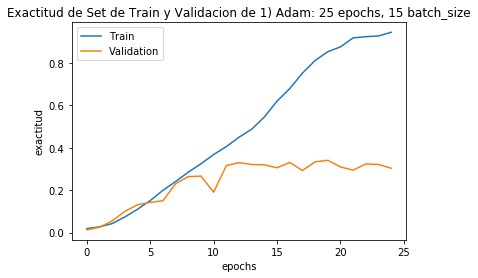

In [14]:
# lines
plt.plot(hist['acc'])
plt.plot(hist['val_acc'])

# title
plt.title("Exactitud de Set de Train y Validacion de 1) Adam: 25 epochs, 15 batch_size")

# labels de los ejes
plt.ylabel('exactitud')
plt.xlabel('epochs')

# leyenda
plt.legend(['Train', 'Validation'])

##### 2) Graficos: Adam: 25 epochs, 30 batch_size

In [31]:
with open('./history/2', 'rb') as f:
    hist = pickle.load(f)

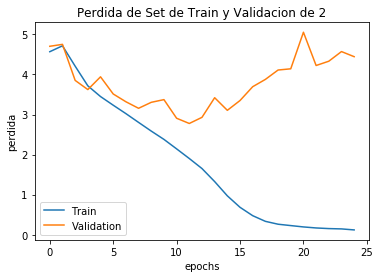

In [32]:
# lines
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])

# title
plt.title("Perdida de Set de Train y Validacion de 2")

# labels de los ejes
plt.ylabel('perdida')
plt.xlabel('epochs')

# leyenda
plt.legend(['Train', 'Validation'])

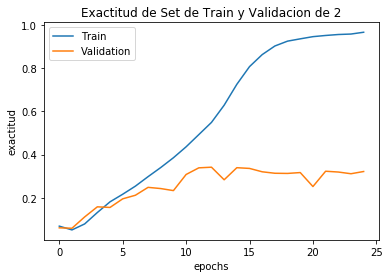

In [33]:
# lines
plt.plot(hist['acc'])
plt.plot(hist['val_acc'])

# title
plt.title("Exactitud de Set de Train y Validacion de 2")

# labels de los ejes
plt.ylabel('exactitud')
plt.xlabel('epochs')

# leyenda
plt.legend(['Train', 'Validation'])

##### 3) Graficos: Adam: 25 epochs, 45 batch_size

In [34]:
with open('./history/3', 'rb') as f:
    hist = pickle.load(f)

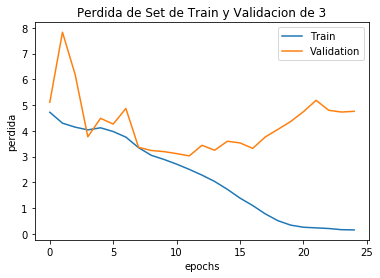

In [35]:
# lines
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])

# title
plt.title("Perdida de Set de Train y Validacion de 3")

# labels de los ejes
plt.ylabel('perdida')
plt.xlabel('epochs')

# leyenda
plt.legend(['Train', 'Validation'])

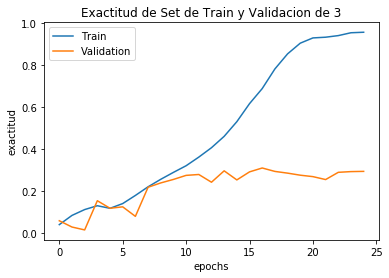

In [36]:
# lines
plt.plot(hist['acc'])
plt.plot(hist['val_acc'])

# title
plt.title("Exactitud de Set de Train y Validacion de 3")

# labels de los ejes
plt.ylabel('exactitud')
plt.xlabel('epochs')

# leyenda
plt.legend(['Train', 'Validation'])

##### 4) Graficos: Adadelta: 25 epochs, 15 batch_size

In [37]:
with open('./history/4', 'rb') as f:
    hist = pickle.load(f)

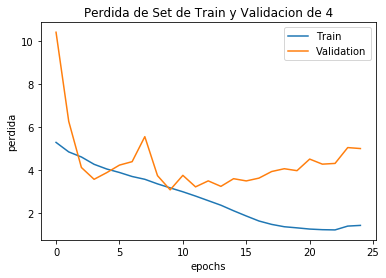

In [38]:
# lines
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])

# title
plt.title("Perdida de Set de Train y Validacion de 4")

# labels de los ejes
plt.ylabel('perdida')
plt.xlabel('epochs')

# leyenda
plt.legend(['Train', 'Validation'])

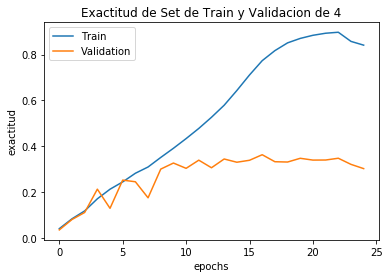

In [39]:
# lines
plt.plot(hist['acc'])
plt.plot(hist['val_acc'])

# title
plt.title("Exactitud de Set de Train y Validacion de 4")

# labels de los ejes
plt.ylabel('exactitud')
plt.xlabel('epochs')

# leyenda
plt.legend(['Train', 'Validation'])

##### 5) Graficos: Adadelta: 25 epochs, 30 batch_size

In [24]:
with open('./history/5', 'rb') as f:
    hist = pickle.load(f)

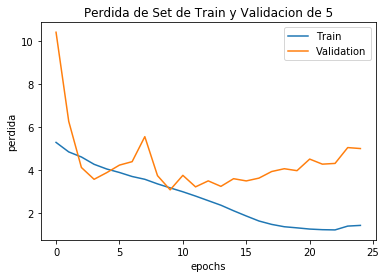

In [40]:
# lines
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])

# title
plt.title("Perdida de Set de Train y Validacion de 5")

# labels de los ejes
plt.ylabel('perdida')
plt.xlabel('epochs')

# leyenda
plt.legend(['Train', 'Validation'])

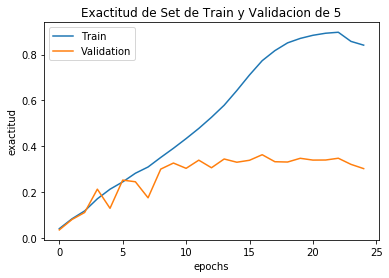

In [41]:
# lines
plt.plot(hist['acc'])
plt.plot(hist['val_acc'])

# title
plt.title("Exactitud de Set de Train y Validacion de 5")

# labels de los ejes
plt.ylabel('exactitud')
plt.xlabel('epochs')

# leyenda
plt.legend(['Train', 'Validation'])

##### 6) Graficos: Adadelta: 25 epochs, 45 batch_size

In [42]:
with open('./history/6', 'rb') as f:
    hist = pickle.load(f)

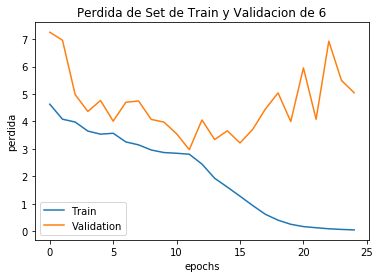

In [43]:
# lines
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])

# title
plt.title("Perdida de Set de Train y Validacion de 6")

# labels de los ejes
plt.ylabel('perdida')
plt.xlabel('epochs')

# leyenda
plt.legend(['Train', 'Validation'])

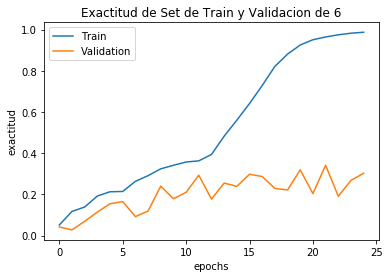

In [45]:
# lines
plt.plot(hist['acc'])
plt.plot(hist['val_acc'])

# title
plt.title("Exactitud de Set de Train y Validacion de 6")

# labels de los ejes
plt.ylabel('exactitud')
plt.xlabel('epochs')

# leyenda
plt.legend(['Train', 'Validation'])

##### Analisis

Primero, vemos en todos los graficos comportamientos similares independiente del Experimento. En los gráficos Perdida v/s Epochs; el Train con el Validation en un comienzo bajan homogeneamente, pero desde un punto (distinto para cada experimento) se separan, siendo que el Train continua bajando y el Validate comienza a subir. Tambien en los gráficos de Exactitud v/s Epochs; el Train con el Validation en un comienzo suben homogenamente, pero desde un punto (distinto para cada experimento) se separan, siendo que el Train continua subiendo y el Validate converge. Estas "separaciones" se deben a un **sobre-entrenamiento.**

También vemos que el batch_size no genera discrepancias en los modelos en terminos de exactitud y perdida.

En términos de el Algoritmo de Optimización observamos que Adam tiene un mejor Accuracy en el Validation sin embargo converge más lento (aproximadamente la epoch 12-13) que Adadelta que converge alrededor de la epoch 7-8. Estos puntos también son los puntos que es la "separación" mencionada anteriormente.

#### Actividad 9

Vamos a quedarnos con el modelo 1

In [52]:
# Definiendo parametros

# numero de epocas para entrenar, uno de los hiperparametros que voy a variar
epochs = 25  

# batch size, uno de los hiperparametros que voy a variar

batch_size = 15 

# Optimizador para entrenar, uno de los hiperparametros que voy a variar
opt = 'adam'

# Definiendo algunos parametros CONSTANTES:

# Numero de clases, por default del ejercicio son 100, constante
num_clases = 100

# dimensiones de las imagenes (tambien por default del ejercicio, constante)
img_width, img_height = 84, 84  

In [53]:
# Source: https://github.com/priya-dwivedi/Deep-Learning/blob/master/resnet_keras/Residual_Network_Keras.ipynb
base_model = applications.resnet50.ResNet50(weights= None, include_top=False, input_shape= (img_height,img_width,3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(num_clases, activation= 'softmax')(x)
    
model = Model(inputs = base_model.input, outputs = predictions)


/home/cuda/.local/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [54]:
model.load_weights("./models/1/weights-improvement-20-0.34.hdf5")


#compile 
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [55]:
# Images Genrators
# Source: https://machinelearningmastery.com/how-to-load-large-datasets-from-directories-for-deep-learning-with-keras/
# Comment of Paulo Henrique Zen Messerschmidt

# create generator
datagen = ImageDataGenerator()

train_set = datagen.flow_from_directory('./data/train/', 
                                       target_size=(img_width, img_height),
                                       batch_size=batch_size)

test_set = datagen.flow_from_directory('./data/test/', 
                                       target_size=(img_width, img_height),
                                       batch_size=batch_size)

val_set = datagen.flow_from_directory('./data/val/', 
                                       target_size=(img_width, img_height),
                                       batch_size=batch_size)

Found 42000 images belonging to 100 classes.
Found 9000 images belonging to 100 classes.
Found 9000 images belonging to 100 classes.


In [13]:
pred_test = model.evaluate_generator(test_set, steps=9000/batch_size)
print('acc en Test: ', pred_test[1] * 100, '%')

acc en Test:  34.922223164389536 %


In [14]:
pred_val = model.evaluate_generator(val_set, steps=9000/batch_size)
print('acc en Validacion: ', pred_val[1] * 100, '%')

acc en Validacion:  34.11111204201976 %


In [15]:
pred_train = model.evaluate_generator(train_set, steps=42000/batch_size)
print('acc en Train: ', pred_train[1] * 100, '%')

acc en Train:  93.05238136649132 %


Vemos que las exactitudes de los sets de test y validación son similares, siendo alrededor de 34%. Por otro lado, el Test de Train nos da una exactitud de 93%. Esto es un reflejo primero que nuesta estrategia de validación funciona y también que hay un claro sobre-entrenamiento.

In [50]:
from sklearn.metrics import classification_report, confusion_matrix

In [56]:
# Source: https://gist.github.com/RyanAkilos/3808c17f79e77c4117de35aa68447045

#Confution Matrix and Classification Report
Y_pred = model.predict_generator(test_set, 9000/batch_size)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_set.classes, y_pred))


Confusion Matrix
[[1 0 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [1 1 1 ... 1 0 1]
 ...
 [0 1 1 ... 1 0 1]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 3 0]]


In [64]:
print('Classification Report')
target_names = [str(i) for i in range(100)]
print(classification_report(test_set.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

           0       0.01      0.01      0.01        90
           1       0.03      0.02      0.03        90
           2       0.01      0.01      0.01        90
           3       0.02      0.01      0.01        90
           4       0.01      0.01      0.01        90
           5       0.02      0.01      0.01        90
           6       0.02      0.01      0.01        90
           7       0.01      0.01      0.01        90
           8       0.02      0.04      0.03        90
           9       0.02      0.01      0.01        90
          10       0.02      0.02      0.02        90
          11       0.01      0.01      0.01        90
          12       0.00      0.00      0.00        90
          13       0.00      0.00      0.00        90
          14       0.00      0.00      0.00        90
          15       0.01      0.01      0.01        90
          16       0.01      0.01      0.01        90
     

Vemos que el mejor es la clase 19 que corresponde a **n02108551** correspondiente a **Tibetan mastiff** La peor corresponde a 99 por ejemplo correspondiente a **n13133613** correspondiente a **ear, spike, capitulum**

* Tibetan mastiff: 
    <img src="./mini_ImageNet/images/n02108551/n0210855100000006.jpg">
    
* ear:
    <img src="./mini_ImageNet/images/n13133613/n1313361300000160.jpg">
    
* spike:
    <img src="./mini_ImageNet/images/n13133613/n1313361300000170.jpg">
    
* capitulum:
    <img src="./mini_ImageNet/images/n13133613/n1313361300000192.jpg">



Vemos que la más facil es dacil de detectar, y luego las otras es más complicado.

### 2.2 Places-25

Al tener el problema con la Clase Sauna, se toma la decisión de eliminarla. Entonces en verdad sería una Places-24

In [11]:
for j in os.listdir('./Places-24/test/'): 
    pass
#     print(len(os.listdir('./Places-24/test/' + j)))

#### Actividad 10

El conjunto de datos utilizados es el recomendado por el Equipo Docente, Places-25. Como fue mencionado anteriormente, al tener el problema con la Clase Sauna, se toma la decisión de eliminarla. Entonces en verdad sería una Places-24.

El número de imagenes es **119.681**. Tenemos **24 clases**. **4.986** imagenes en promedio por cada clase.

También tenemos:

Set |Numero de Imagenes | Numero de imagenes promedio por clase
--- | --- | ---
*Train* | 96000 | 40000
*Val* | 12000 | 500
*Test* | 11681 | 487


**La Distribución de imagenes por cada clase:**

Clase |Set_Train | Set_Val | Set_Test
--- | --- | --- | --- 
1. ballroom | 4000 | 500 | 500
2. beer_hall | 4000 | 500 | 500
3. bullring | 4000 | 500 | 500
4. campsite | 4000 | 500 | 500
5. castle | 4000 | 500 | 500
6. courthouse | 4000 | 500 | 500
7. entrance_hall | 4000 | 500 | 500
8. excavation | 4000 | 500 | 500
9. forest_road | 4000 | 500 | 500
10. hotel-outdoor | 4000 | 500 | 500
11. industrial_area | 4000 | 500 | 500
12. manufactured_home | 4000 | 500 | 500
13. motel | 4000 | 500 | 500
14. pond | 4000 | 500 | 500
15. ruin | 4000 | 500 | 500
16. sandbox | 4000 | 500 | 500
17. shopfront | 4000 | 500 | 500
18. slum | 4000 | 500 | 500
19. tower | 4000 | 500 | 500
20. vegetable_garden | 4000 | 500 | 500
21. volcano | 4000 | 500 | 500
22. water_park | 4000 | 500 | 500
23. youth_hostel | 4000 | 500 | 500
24. zen_garden | 4000 | 181 | 500

**Algunas Clases de ejemplo:**
* Ballroom: 
    <img src="./Places-25/test/ballroom/00000006.jpg">
    
* Sandbox:
    <img src="./Places-25/test/sandbox/00000167.jpg">


#### Actividad 11

#### Defining Hyperparameters

In [4]:
# Definiendo algunos parametros CONSTANTES:

# Numero de clases, por default del ejercicio son 100, constante
num_clases = 24

# dimensiones de las imagenes (tambien por default del ejercicio, constante)
img_width, img_height = 256, 256  

#### 1) Adam

In [6]:
# Source: https://github.com/priya-dwivedi/Deep-Learning/blob/master/resnet_keras/Residual_Network_Keras.ipynb
base_model = applications.resnet50.ResNet50(weights= None, include_top=False, input_shape= (img_height,img_width,3))

/home/cuda/.local/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [7]:
# Definiendo parametros

# numero de epocas para entrenar, uno de los hiperparametros que voy a variar
epochs = 18  

# batch size, uno de los hiperparametros que voy a variar

batch_size = 40 

# Optimizador para entrenar, uno de los hiperparametros que voy a variar
opt = 'adam'


In [8]:
# Source: https://machinelearningmastery.com/how-to-load-large-datasets-from-directories-for-deep-learning-with-keras/
# Comment of Paulo Henrique Zen Messerschmidt

# create generator
datagen = ImageDataGenerator()

train_set = datagen.flow_from_directory('./Places-24/train/', 
                                       target_size=(img_width, img_height),
                                       batch_size=batch_size)

test_set = datagen.flow_from_directory('./Places-24/test/', 
                                       target_size=(img_width, img_height),
                                       batch_size=batch_size)

val_set = datagen.flow_from_directory('./Places-24/val/', 
                                       target_size=(img_width, img_height),
                                       batch_size=batch_size)

Found 96000 images belonging to 24 classes.
Found 12000 images belonging to 24 classes.
Found 11681 images belonging to 24 classes.


In [9]:

x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(num_clases, activation= 'softmax')(x)
    
model = Model(inputs = base_model.input, outputs = predictions)

#compile 
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


In [10]:
# Source: https://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/
# https://github.com/keras-team/keras/issues/8540/
# https://keras.io/callbacks/
# https://machinelearningmastery.com/check-point-deep-learning-models-keras/

# checkpoint
filepath='./models/places/weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max', save_weights_only=True)
callbacks_list = [checkpoint]

# training
hist = model.fit_generator(generator=train_set,
                              validation_data=val_set,
                              epochs = epochs,
                              verbose = 1,
                              callbacks=callbacks_list,
                              steps_per_epoch=96000/batch_size,
                              validation_steps=11681/batch_size)


Epoch 1/18
2400/2400 [==============================] - 859s 358ms/step - loss: 2.0667 - acc: 0.3832 - val_loss: 4.5132 - val_acc: 0.1563
Epoch 2/18
2400/2400 [==============================] - 847s 353ms/step - loss: 1.4039 - acc: 0.5665 - val_loss: 1.7786 - val_acc: 0.4774
Epoch 3/18
2400/2400 [==============================] - 845s 352ms/step - loss: 1.1576 - acc: 0.6408 - val_loss: 3.2606 - val_acc: 0.2634
Epoch 4/18
2400/2400 [==============================] - 845s 352ms/step - loss: 1.0139 - acc: 0.6860 - val_loss: 1.5256 - val_acc: 0.5262
Epoch 5/18
2400/2400 [==============================] - 844s 352ms/step - loss: 0.8737 - acc: 0.7271 - val_loss: 1.3871 - val_acc: 0.5892
Epoch 6/18
2400/2400 [==============================] - 845s 352ms/step - loss: 0.7714 - acc: 0.7571 - val_loss: 1.7347 - val_acc: 0.4725
Epoch 7/18
2400/2400 [==============================] - 844s 352ms/step - loss: 0.6822 - acc: 0.7820 - val_loss: 1.0748 - val_acc: 0.6726
Epoch 8/18
2400/2400 [============

In [11]:
with open('./history/places_1', 'wb') as file:
        pickle.dump(hist.history, file)

#### 2) Adadelta

In [10]:
# Source: https://github.com/priya-dwivedi/Deep-Learning/blob/master/resnet_keras/Residual_Network_Keras.ipynb
base_model = applications.resnet50.ResNet50(weights= None, include_top=False, input_shape= (img_height,img_width,3))

In [13]:
# Definiendo parametros

# numero de epocas para entrenar, uno de los hiperparametros que voy a variar
epochs = 20  

# batch size, uno de los hiperparametros que voy a variar

batch_size = 40 

# Optimizador para entrenar, uno de los hiperparametros que voy a variar
opt = 'adadelta'


In [14]:
# Source: https://machinelearningmastery.com/how-to-load-large-datasets-from-directories-for-deep-learning-with-keras/
# Comment of Paulo Henrique Zen Messerschmidt

# create generator
datagen = ImageDataGenerator()

train_set = datagen.flow_from_directory('./Places-24/train/', 
                                       target_size=(img_width, img_height),
                                       batch_size=batch_size)

test_set = datagen.flow_from_directory('./Places-24/test/', 
                                       target_size=(img_width, img_height),
                                       batch_size=batch_size)

val_set = datagen.flow_from_directory('./Places-24/val/', 
                                       target_size=(img_width, img_height),
                                       batch_size=batch_size)

Found 96000 images belonging to 24 classes.
Found 12000 images belonging to 24 classes.
Found 11681 images belonging to 24 classes.


In [15]:

x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(num_clases, activation= 'softmax')(x)
    
model = Model(inputs = base_model.input, outputs = predictions)

#compile 
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


In [16]:
# Source: https://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/
# https://github.com/keras-team/keras/issues/8540/
# https://keras.io/callbacks/
# https://machinelearningmastery.com/check-point-deep-learning-models-keras/

# checkpoint
filepath='./models/places_2/weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max', save_weights_only=True)
callbacks_list = [checkpoint]

# training
hist = model.fit_generator(generator=train_set,
                              validation_data=val_set,
                              epochs = epochs,
                              verbose = 1,
                              callbacks=callbacks_list,
                              steps_per_epoch=96000/batch_size,
                              validation_steps=11681/batch_size)


Epoch 1/20
2400/2400 [==============================] - 879s 366ms/step - loss: 1.9559 - acc: 0.4181 - val_loss: 2.5439 - val_acc: 0.3816
Epoch 2/20
2400/2400 [==============================] - 869s 362ms/step - loss: 1.2433 - acc: 0.6148 - val_loss: 1.9063 - val_acc: 0.4947
Epoch 3/20
2400/2400 [==============================] - 869s 362ms/step - loss: 1.0125 - acc: 0.6836 - val_loss: 2.0800 - val_acc: 0.4652
Epoch 4/20
2400/2400 [==============================] - 868s 362ms/step - loss: 0.8693 - acc: 0.7273 - val_loss: 1.9967 - val_acc: 0.4548
Epoch 5/20
2400/2400 [==============================] - 869s 362ms/step - loss: 0.7702 - acc: 0.7575 - val_loss: 1.3107 - val_acc: 0.6066
Epoch 6/20
2400/2400 [==============================] - 869s 362ms/step - loss: 0.6851 - acc: 0.7838 - val_loss: 1.2663 - val_acc: 0.6276
Epoch 7/20
2400/2400 [==============================] - 869s 362ms/step - loss: 0.6079 - acc: 0.8034 - val_loss: 1.0538 - val_acc: 0.6944
Epoch 8/20
2400/2400 [============

In [17]:
with open('./history/places_2', 'wb') as file:
        pickle.dump(hist.history, file)

#### Actividad 12

Vamos a graficar ambos experimentos y luego analizar

##### Adam

In [19]:
with open('./history/places_1', 'rb') as f:
    hist = pickle.load(f)

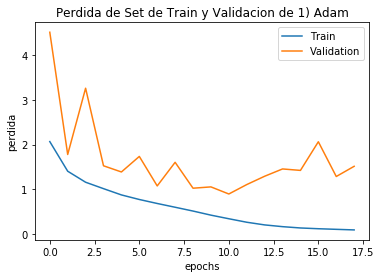

In [20]:
# lines
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])

# title
plt.title("Perdida de Set de Train y Validacion de 1) Adam")

# labels de los ejes
plt.ylabel('perdida')
plt.xlabel('epochs')

# leyenda
plt.legend(['Train', 'Validation'])

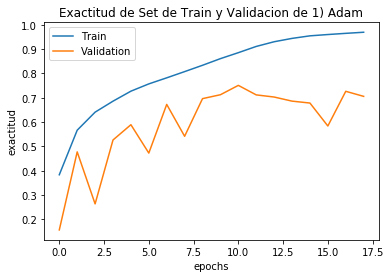

In [21]:
# lines
plt.plot(hist['acc'])
plt.plot(hist['val_acc'])

# title
plt.title("Exactitud de Set de Train y Validacion de 1) Adam")

# labels de los ejes
plt.ylabel('exactitud')
plt.xlabel('epochs')

# leyenda
plt.legend(['Train', 'Validation'])

##### Adadelta

In [22]:
with open('./history/places_2', 'rb') as f:
    hist = pickle.load(f)

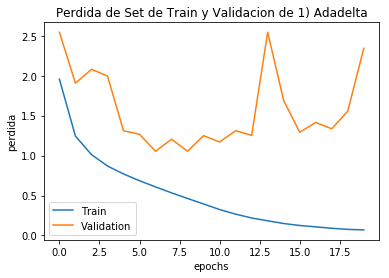

In [26]:
# lines
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])

# title
plt.title("Perdida de Set de Train y Validacion de 1) Adadelta")

# labels de los ejes
plt.ylabel('perdida')
plt.xlabel('epochs')

# leyenda
plt.legend(['Train', 'Validation'])

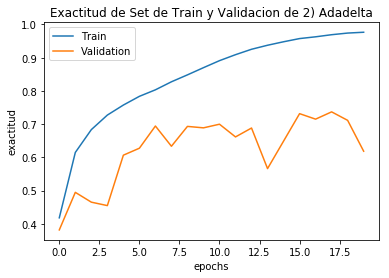

In [25]:
# lines
plt.plot(hist['acc'])
plt.plot(hist['val_acc'])

# title
plt.title("Exactitud de Set de Train y Validacion de 2) Adadelta")

# labels de los ejes
plt.ylabel('exactitud')
plt.xlabel('epochs')

# leyenda
plt.legend(['Train', 'Validation'])

##### Analisis

Primero se observa a grandes rasgos que ambos experimentos tienen comportamientos similares. En los gráficos Perdida v/s Epochs; el Train baja sumamente bien, en cambio el Validate baja también un tanto desrodeando,  pero desde un punto (distinto para cada experimento) comienza a subir. Este punto es antes para el Adadelta.

Tambien en los gráficos de Exactitud v/s Epochs; el Train va subiendo sumamente ordenado (hemogeneo), el Validate sube al principio pero más desordenado, pero desde un punto (distinto para cada experimento) se separan, siendo que el Train continua subiendo y el Validate converge.Estas "separaciones" se deben a un **sobre-entrenamiento.**


En términos de el Algoritmo de Optimización observamos que Adam tiene un mejor Accuracy en el Validation sin embargo converge más lento (aproximadamente la epoch 10) que Adadelta que converge alrededor de la epoch 5. Estos puntos también son los puntos que es la "separación" mencionada anteriormente.

#### Actividad 13

Nos vamos a quedar con el modelo 1 de Adam

In [27]:
# Definiendo parametros

# numero de epocas para entrenar, uno de los hiperparametros que voy a variar
epochs = 18  

# batch size, uno de los hiperparametros que voy a variar

batch_size = 40 

# Optimizador para entrenar, uno de los hiperparametros que voy a variar
opt = 'adam'


# Definiendo algunos parametros CONSTANTES:

# Numero de clases, por default del ejercicio son 100, constante
num_clases = 24

# dimensiones de las imagenes (tambien por default del ejercicio, constante)
img_width, img_height = 256, 256  

In [28]:
# Source: https://github.com/priya-dwivedi/Deep-Learning/blob/master/resnet_keras/Residual_Network_Keras.ipynb
base_model = applications.resnet50.ResNet50(weights= None, include_top=False, input_shape= (img_height,img_width,3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(num_clases, activation= 'softmax')(x)
    
model = Model(inputs = base_model.input, outputs = predictions)


/home/cuda/.local/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [29]:
model.load_weights("./models/places/weights-improvement-11-0.75.hdf5")


#compile 
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
# Source: https://machinelearningmastery.com/how-to-load-large-datasets-from-directories-for-deep-learning-with-keras/
# Comment of Paulo Henrique Zen Messerschmidt

# create generator
datagen = ImageDataGenerator()

train_set = datagen.flow_from_directory('./Places-24/train/', 
                                       target_size=(img_width, img_height),
                                       batch_size=batch_size)

test_set = datagen.flow_from_directory('./Places-24/test/', 
                                       target_size=(img_width, img_height),
                                       batch_size=batch_size)

val_set = datagen.flow_from_directory('./Places-24/val/', 
                                       target_size=(img_width, img_height),
                                       batch_size=batch_size)

Found 96000 images belonging to 24 classes.
Found 12000 images belonging to 24 classes.
Found 11681 images belonging to 24 classes.


In [31]:
pred_test = model.evaluate_generator(test_set, steps=12000/batch_size)
print('acc en Test: ', pred_test[1] * 100, '%')

acc en Test:  75.65833332141241 %


In [32]:
pred_val = model.evaluate_generator(val_set, steps=11681/batch_size)
print('acc en Validacion: ', pred_val[1] * 100, '%')

acc en Validacion:  75.09631023108169 %


In [33]:
pred_train = model.evaluate_generator(train_set, steps=96000/batch_size)
print('acc en Train: ', pred_train[1] * 100, '%')

acc en Train:  92.12291661649942 %


Vemos que las exactitudes de los sets de test y validación son similares, siendo alrededor de 76%. Por otro lado, el Test de Train nos da una exactitud de 92%. Esto es un reflejo primero que nuesta estrategia de validación funciona y también que hay un claro sobre-entrenamiento.

Tambien vemos que al tener más imagenes en caso del ejemplo anterior (mini-ImageNet), tenemos mejores accuracy, dado que el numero de datos es fundamental en Deep Learning.

In [45]:
from sklearn.metrics import classification_report, confusion_matrix

In [46]:
# Source: https://gist.github.com/RyanAkilos/3808c17f79e77c4117de35aa68447045

#Confution Matrix and Classification Report
Y_pred = model.predict_generator(test_set, 12000/batch_size)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_set.classes, y_pred))


Confusion Matrix
[[32 21 22  8 19 21 24 20 15 21 28 21 18 38 22 10 10 23 16 21 17 30 22 21]
 [37 20 23 12 21 15 19 20 19 27 30 14 13 22 19 11 28 15 18 29 24 21 19 24]
 [20 17 16 11 19 16 24 29 19 23 20  8 20 31 22 16 22 12 18 27 26 34 25 25]
 [32 11 22 20 14 15 20 20 16 16 17 18 25 28 25 22 24 18 21 22 22 30 18 24]
 [27 23 24 23 16  8 17 13 25 19 20 20 29 28 18 18 26 14 20 24 23 26 22 17]
 [37 28 17 14 11 20 16 17 23 25 16 22 15 33 21 21 26 22 17 25 16 22 18 18]
 [34 17 23 14 16 22 22 17 22 16 24 25 17 34 20 12 17 22 22 22 15 22 27 18]
 [23 18 23 16 20 25 30 17 20 26 31 20 20 28 17 13 19 17 21 14 12 22 23 25]
 [37 16 13 18 22 15 21 18 19 14 22 20 27 22 20 20 24 23 19 17 27 30 21 15]
 [36 22 16 18 20 23 20 16 27 12 27 20 16 22 26  8 27 21 13 20 24 17 22 27]
 [24 18 24 18 12 26 22 12 12 17 24 22 16 31 28 16 25 22 24 18 13 27 21 28]
 [30 16 21 13 14 25 17 15 15 23 18 20 17 34 29 14 24 20 18 18 25 34 20 20]
 [28 24 19 14 14 24 17 20 14 19 17 25 18 27 27 20 17 19 16 26 17 36 22 20]
 [26 19 

In [49]:
print('Classification Report')
target_names = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24']
print(classification_report(test_set.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

           1       0.04      0.06      0.05       500
           2       0.05      0.04      0.04       500
           3       0.03      0.03      0.03       500
           4       0.05      0.04      0.05       500
           5       0.04      0.03      0.04       500
           6       0.04      0.04      0.04       500
           7       0.05      0.04      0.05       500
           8       0.04      0.03      0.04       500
           9       0.04      0.04      0.04       500
          10       0.02      0.02      0.02       500
          11       0.04      0.05      0.04       500
          12       0.04      0.04      0.04       500
          13       0.04      0.04      0.04       500
          14       0.03      0.04      0.03       500
          15       0.04      0.05      0.05       500
          16       0.04      0.03      0.03       500
          17       0.04      0.04      0.04       500
     

Vemos que la con peor es la 14 correspondiente a **pond** y la mejor la 24 correspondiente a **zen_garden**

* pond: 
    <img src="./Places-25/test/pond/00000006.jpg">
    
* zen_garden:
    <img src="./Places-25/test/zen_garden/00000167.jpg">


Vemos que Zen Garden es muy facil de clasificar a simple vista, sin embargo pond puede ser  muy variante